In [1]:
require(ggplot2)
require(mgcv)
require(lme4)
require(dplyr)
require(akima)
require(grid)
require(gridExtra)

Loading required package: ggplot2

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

Loading required package: lme4

Loading required package: Matrix


Attaching package: 'lme4'


The following object is masked from 'package:nlme':

    lmList


Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: akima

Loading required package: grid

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
data = read.csv("data/rolemean_pca20.csv")
data$filename = factor(data$filename)
data$point_pct = factor(data$point_pct)
data = data[data$speaker=='A',]

In [3]:
data$annot_id = paste0(data$person, data$t_start)

In [4]:
bpc_vars = paste(grep("bpc_.*", names(data), value=T), collapse="+")

## Mixed model

In [5]:
nrow(data)

[1] 715

In [22]:
form.f1 = as.formula(paste0("freq_f1~", bpc_vars, "+(1|filename)+(1|point_pct)"))
# form.f1 = as.formula("freq_f1~tsne_0+tsne_1+(1|filename)+(1|point_pct)")
m_f1 = lmer(form.f1, data=data)

In [23]:
form.f2 = as.formula(paste0("freq_f2~", bpc_vars, "+(1|filename)+(1|point_pct)"))
# form.f2 = as.formula("freq_f2~tsne_0+tsne_1+(1|filename)+(1|point_pct)")
m_f2 = lmer(form.f2, data=data)

In [24]:
form.f3 = as.formula(paste0("freq_f3~", bpc_vars, "+(1|filename)+(1|point_pct)"))
# form.f3 = as.formula("freq_f3~tsne_0+tsne_1+(1|filename)+(1|point_pct)")
m_f3 = lmer(form.f3, data=data)

In [25]:
form.a1p0 = as.formula(paste0("a1p0~", bpc_vars, "+(1|filename)+(1|point_pct)"))
# form.a1p0 = as.formula("a1p0~tsne_0+tsne_1+(1|filename)+(1|point_pct)")
m_a1p0 = lmer(form.a1p0, data=data)

## Get prediction error (bootstrap)

In [26]:
pred.func <- function(fit) {
    predict(fit, re.form=NA)
}
nbin=4

### F1 predictions

In [27]:
boot_lmer = function(lme_obj){
    boot_obj = bootMer(lme_obj, nsim=200, FUN=pred.func,seed=101)
    pred_mean = apply(boot_obj$t, 2, mean)
    pred_se = apply(boot_obj$t, 2, sd)
    interp_se = interp(data$tsne_0, data$tsne_1, pred_se, duplicate="mean")    
    interp_M = interp(data$tsne_0, data$tsne_1, pred_mean, duplicate="mean")
    grid_obj = expand.grid(interp_M$x, interp_M$y)
    names(grid_obj) = c("comp1", "comp2")
    grid_obj$M = as.numeric(interp_M$z)    
    grid_obj$se = as.numeric(interp_se$z)
    grid_obj = grid_obj[apply(!is.na(grid_obj[,c("M", "se")]), 1, all),]
    list(pred_mean=pred_mean, pred_se=pred_se, grid_df=grid_obj)
}

In [28]:
boot_pred_f1 = boot_lmer(m_f1)
boot_pred_f2 = boot_lmer(m_f2)
boot_pred_f3 = boot_lmer(m_f3)
boot_pred_nas = boot_lmer(m_a1p0)

In [39]:
Gn = "#1b9e77"
Rd = "#d95f02"
plot_acoustic_effect = function(boot_pred, var_label, 
                                k=0.5, breaks=NULL){
    pred_mean = boot_pred$pred_mean
    pred_se = boot_pred$pred_se
    grid_df = boot_pred$grid_df
    pred_df = data.frame(x=data$tsne_0, y=data$tsne_1, pred=pred_mean)
    
    if (!is.null(breaks)) {
        M_breaks = breaks
    } else {
        M_breaks = pretty(pred_mean, n=3)
    }
    
    # note sen1 is for +1se, sep1 is for -1se,
    # they all use the same breaks from M, 
    # therefore drawing the same contour line on sen1 is the same as drawing +1se
    # c.f. https://github.com/cran/mgcv/blob/a534170c82ce06ccd8d76b1a7d472c50a2d7bbd2/R/plots.r#L802

    ggplot() + theme_classic() + 
        geom_raster(data=grid_df, aes(x=comp1, y=comp2, fill=M)) +                
        scale_fill_distiller(palette='RdYlGn', direction=1, name=var_label) + 
        geom_contour(data=grid_df, aes(x=comp1, y=comp2, z=M), 
                     color="#636363", breaks=M_breaks, size=0.5) +
        # geom_contour(data=grid_df, aes(x=comp1, y=comp2, z=I(M-k*se)),  # +k*se
        #              color=Gn, breaks=M_breaks, size=1, linetype="longdash") +
        # geom_contour(data=grid_df, aes(x=comp1, y=comp2, z=I(M+k*se)),  # -k*se
        #              color=Rd, breaks=M_breaks, size=1, linetype="longdash") +    
        geom_point(data=pred_df, aes(x=x, y=y), size=1, color="#333333", shape=20) +
        theme(axis.title=element_text(size=12, color="#333333"), 
              axis.text.x=element_text(size=12),
              axis.text.y=element_text(size=12),               
              plot.title=element_text(size=16, hjust=0.5),              
              legend.key.size=unit(1, 'cm'),
              legend.key.height=unit(0.5, 'cm'),
              legend.position="top",
              legend.title=element_blank(),
              legend.text=element_text(size=10)) + 
        xlab("tSNE-1") + ylab("tSNE-2") + ggtitle(var_label)
}

In [40]:
options(repr.plot.width=12, repr.plot.height=4, repr.plot.res=200)
p1 = plot_acoustic_effect(boot_pred_f1, "F1 Freq")
p2 = plot_acoustic_effect(boot_pred_f2, "F2 Freq")
p3 = plot_acoustic_effect(boot_pred_f3, "F3 Freq")
p4 = plot_acoustic_effect(boot_pred_nas, "Nasality")
p_grid = arrangeGrob(p1, p2, p3, p4, nrow=1)

In [41]:
plot_grid = function(gg_grob){
    main_vp = viewport(width=1, height=0.9, x=0, y=0.1, just=c("left", "bottom"))
    pushViewport(main_vp)
    grid.draw(gg_grob)
    popViewport()
    se_vp = viewport(width=1, height=0.1, x=0, y=0, just=c("left", "bottom"))
    pushViewport(se_vp)
    grid.text("−0.5×SE", x=0.5, y=0.5, just=c("right", "center"))
    grid.text("+0.5×SE", x=0.6, y=0.5, just=c("left", "center"))
    grid.lines(x=c(0.41, 0.44), y=0.48, gp=gpar(col=Rd, lwd=3, lty="dashed"))
    grid.lines(x=c(0.55, 0.59), y=0.48, gp=gpar(col=Gn, lwd=3, lty="dashed"))
    popViewport()
}

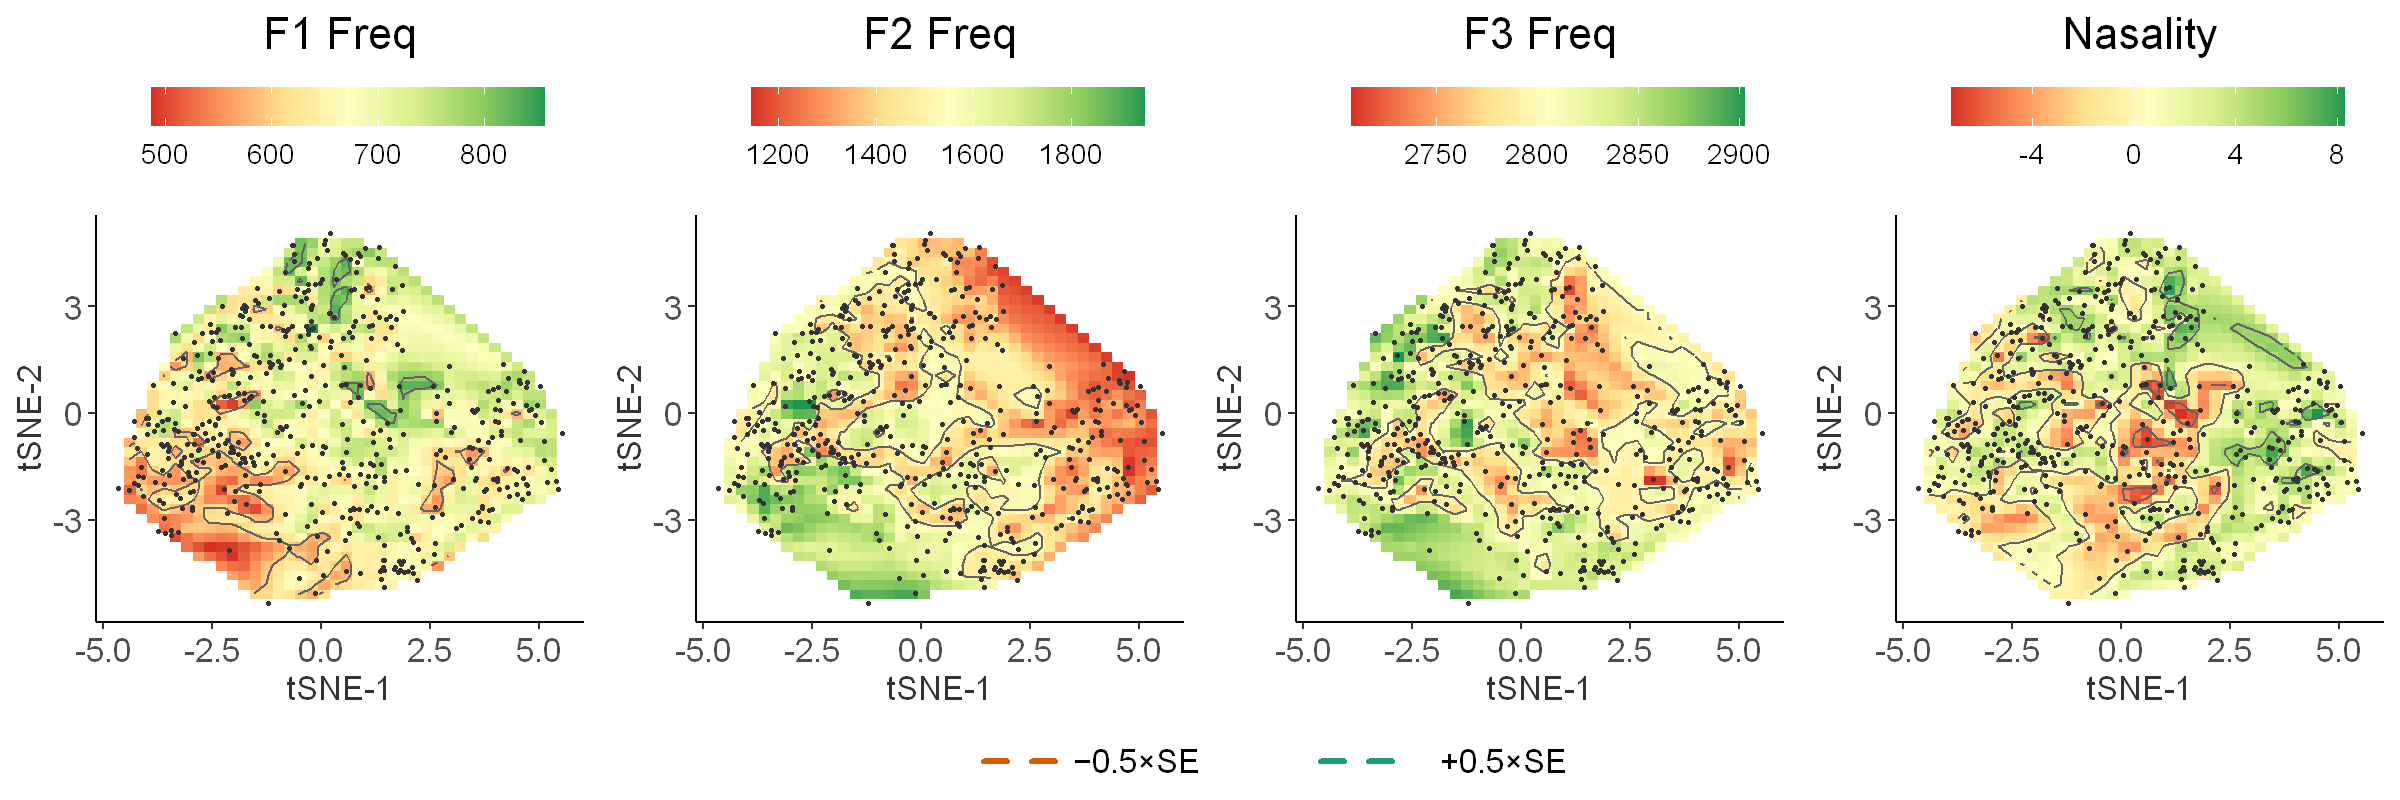

In [42]:
plot_grid(p_grid)

In [47]:
strsplit("aeioɤəu", split='')

[[1]]
[1] "a" "e" "i" "o" "ɤ" "ə" "u"

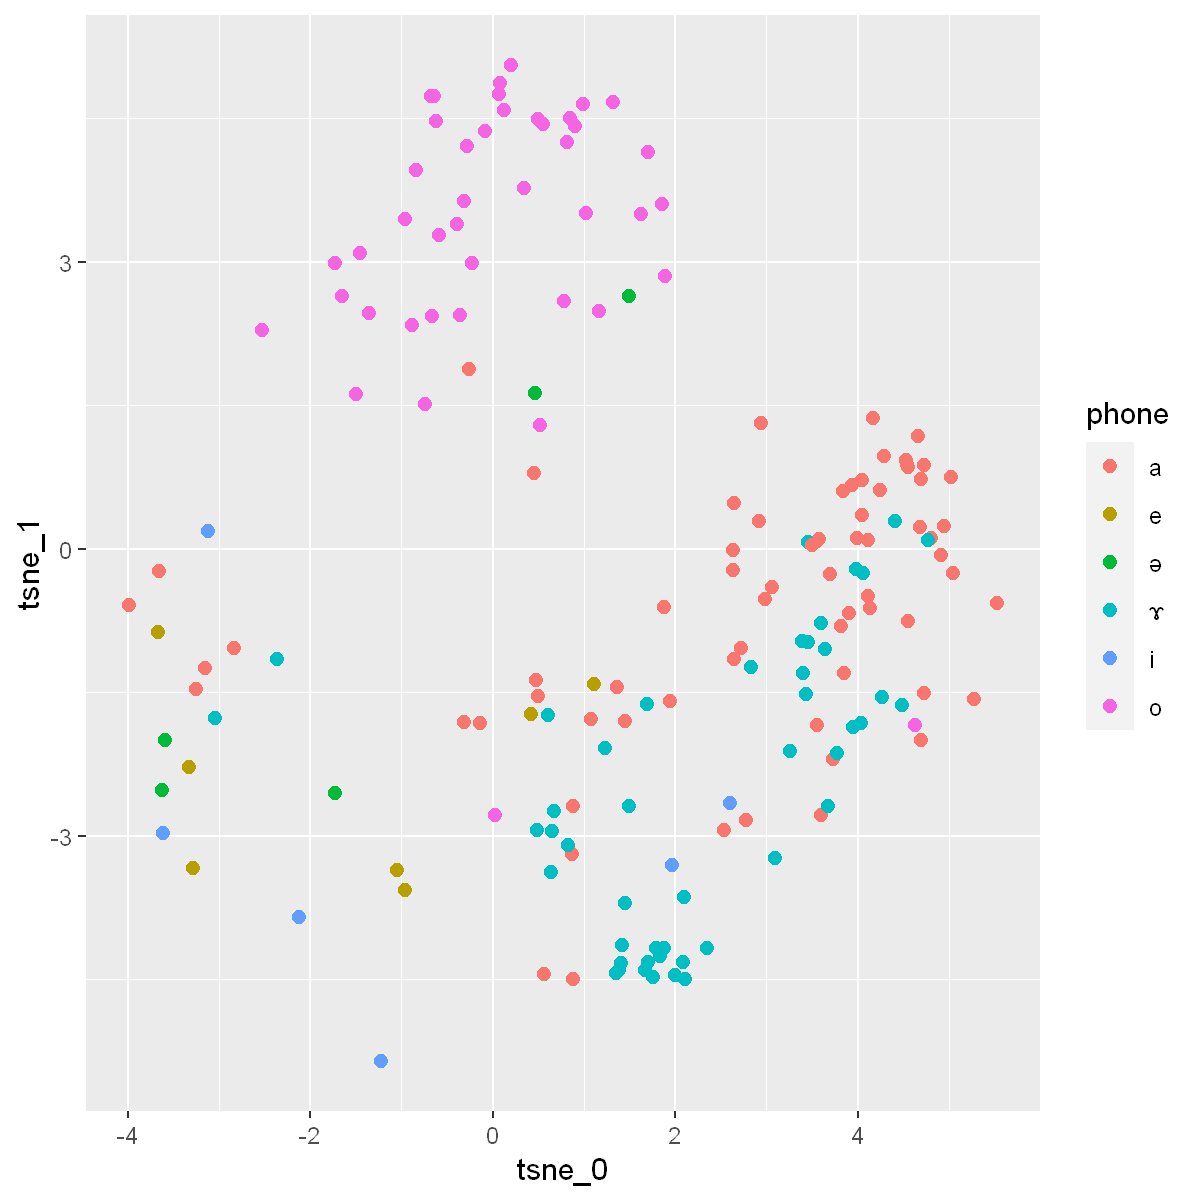

In [48]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=200)
ggplot(data %>% filter(phone %in% strsplit("aeioɤəu", split='')[[1]]), aes(x=tsne_0, y=tsne_1, color=phone))+geom_point(size=2)

In [60]:
png("ac_tsne.png", width=12, height=4, units="in", res=200)
plot_grid(p_grid)
dev.off()

png 
  2